# CryptoBot

In [363]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import json
plt.style.use('fivethirtyeight')

In [364]:
#setting up binance api connector
from binance.client import Client

client = Client()

In [365]:
def getSentiments():
    with open('fear-and-greed-daily.json', 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data['data'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    df = df[['value']]
    df['value'] = pd.to_numeric(df['value'])
    df.rename(columns={'value': 'sentiment'}, inplace=True)
    return df

In [366]:
data_columns = ['date','open','high','low','close','volume']

def getCryptoData(symbol='BTCUSDT', interval='1d', start='2018-02-01', end='2022-07-28'):
    df = pd.DataFrame(client.get_historical_klines(symbol=symbol, interval=interval, start_str=start, end_str=end))
    df = df[[0,1,2,3,4,5]]
    df.columns = data_columns
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])
    df.date = pd.to_datetime(df.date, unit='ms')
    df.set_index('date', inplace=True)
    df['sentiment'] = getSentiments()['sentiment']
    return df

In [367]:
df = getCryptoData()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1639 entries, 2018-02-01 to 2022-07-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1639 non-null   float64
 1   high       1639 non-null   float64
 2   low        1639 non-null   float64
 3   close      1639 non-null   float64
 4   volume     1639 non-null   float64
 5   sentiment  1639 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 89.6 KB


In [368]:
df

,open,high,low,close,volume,sentiment
date,,,,,,
2018-02-01,10285.10,10335.00,8750.99,9224.52,33564.764311,30
2018-02-02,9224.52,9250.00,8010.02,8873.03,49971.626975,15
2018-02-03,8873.03,9473.01,8229.00,9199.96,28725.000735,40
2018-02-04,9199.96,9368.00,7930.00,8184.81,32014.308449,24
2018-02-05,8179.99,8382.80,6625.00,6939.99,63403.182579,11
...,...,...,...,...,...,...
2022-07-24,22448.58,23014.64,22257.15,22579.68,115189.672770,30
2022-07-25,22577.13,22666.00,21250.00,21310.90,180344.766430,30
2022-07-26,21310.90,21347.82,20706.50,21254.67,177817.243260,26


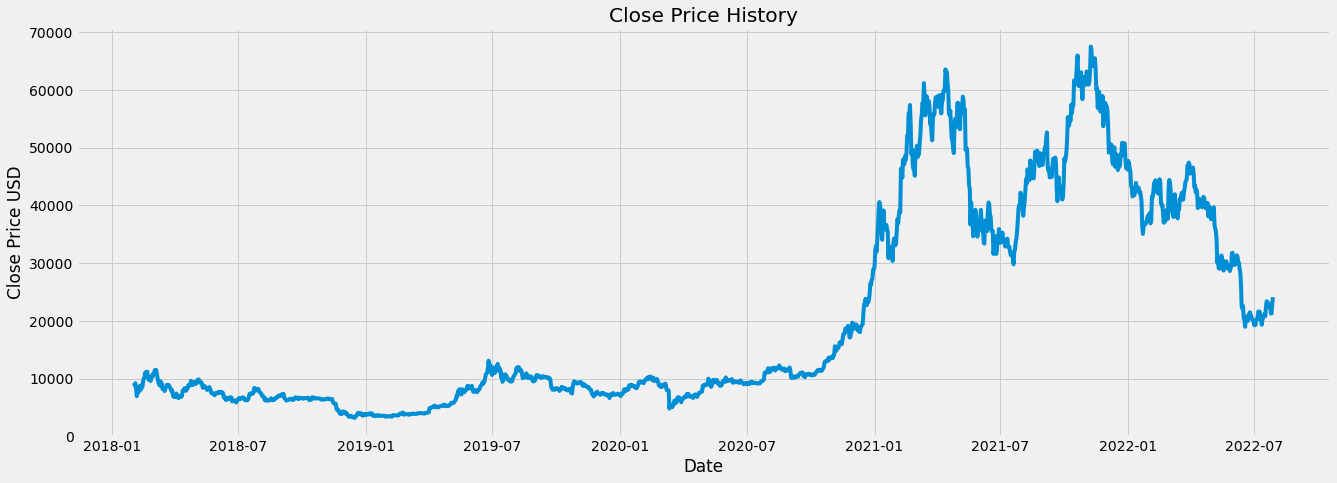

In [369]:
plt.figure(figsize=(20,7))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show()

In [370]:
training_data_len = math.ceil(len(df['close'])*0.8)
training_data_len

1312

In [371]:
test_close = df['close'].copy()
MMS = MinMaxScaler()
df[df.columns] = MMS.fit_transform(df)
df.head()

,open,high,low,close,volume,sentiment
date,,,,,,
2018-02-01,0.109982,0.107397,0.088712,0.093491,0.079797,0.277778
2018-02-02,0.093491,0.090888,0.076963,0.088026,0.120655,0.111111
2018-02-03,0.088026,0.094281,0.080435,0.093109,0.067744,0.388889
2018-02-04,0.093109,0.092684,0.075694,0.077325,0.075936,0.211111
2018-02-05,0.077250,0.077694,0.055002,0.057970,0.154103,0.066667


In [372]:
train_df = df[:training_data_len]
test_df  = df[training_data_len:]
len(train_df), len(test_df)

(1312, 327)

In [373]:
# Function to create sequence of data for training and testing
def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx]['close'])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [374]:
train_seq, train_label = create_sequence(train_df)
test_seq, test_label = create_sequence(test_df)
test_seq.shape

(277, 50, 6)

In [375]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((1262, 50, 6), (1262,), (277, 50, 6), (277,))

In [376]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 50, 50)            11400     
                                                                 
 dropout_12 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_25 (LSTM)              (None, 50)                20200     
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 31,651
Trainable params: 31,651
Non-trainable params: 0
_________________________________________________________________


In [382]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
40/40 [==============================] - 1s 23ms/step - loss: 2.8327e-04 - mean_absolute_error: 0.0095 - val_loss: 0.0011 - val_mean_absolute_error: 0.0253
Epoch 2/80
40/40 [==============================] - 1s 23ms/step - loss: 3.9297e-04 - mean_absolute_error: 0.0130 - val_loss: 8.5711e-04 - val_mean_absolute_error: 0.0226
Epoch 3/80
40/40 [==============================] - 1s 23ms/step - loss: 3.9663e-04 - mean_absolute_error: 0.0121 - val_loss: 7.7345e-04 - val_mean_absolute_error: 0.0209
Epoch 4/80
40/40 [==============================] - 1s 23ms/step - loss: 2.8556e-04 - mean_absolute_error: 0.0100 - val_loss: 8.7546e-04 - val_mean_absolute_error: 0.0224
Epoch 5/80
40/40 [==============================] - 1s 23ms/step - loss: 2.8327e-04 - mean_absolute_error: 0.0098 - val_loss: 8.1945e-04 - val_mean_absolute_error: 0.0218
Epoch 6/80
40/40 [==============================] - 1s 22ms/step - loss: 2.8130e-04 - mean_absolute_error: 0.0099 - val_loss: 7.3043e-04 - val_mean_a

In [383]:
test_predicted = model.predict(test_seq)

9/9 [==============================] - 0s 8ms/step


In [386]:
#new_df = pd.concat([df.iloc[-277:].copy(),pd.DataFrame(test_predicted,columns=['close_predicted'],index=df.iloc[-277:].index)], axis=1)
new_df = df.iloc[-277:].copy()
new_df['close'] = test_predicted
new_df

,open,high,low,close,volume,sentiment
date,,,,,,
2021-10-25,0.896234,0.919521,0.911642,0.807218,0.087988,0.744444
2021-10-26,0.930854,0.913174,0.898442,0.840566,0.096364,0.788889
2021-10-27,0.888096,0.885825,0.869623,0.823103,0.150919,0.755556
2021-10-28,0.858314,0.901086,0.866768,0.813433,0.148259,0.677778
2021-10-29,0.891938,0.908404,0.904107,0.841257,0.105719,0.722222
...,...,...,...,...,...,...
2022-07-24,0.299108,0.300321,0.302871,0.286346,0.283066,0.277778
2022-07-25,0.301107,0.295016,0.286901,0.284009,0.445321,0.277778
2022-07-26,0.281419,0.274960,0.278283,0.277576,0.439027,0.233333


In [387]:
new_df[new_df.columns] = MMS.inverse_transform(new_df)
new_df.rename(columns={'close': 'predicted_close'}, inplace=True)
new_df['close'] = test_close
new_df.head()

,open,high,low,predicted_close,volume,sentiment,close
date,,,,,,,
2021-10-25,60852.22,63710.63,60650.00,55127.216723,36853.83806,72.0,63078.78
2021-10-26,63078.78,63293.48,59817.55,57271.946033,40217.50083,76.0,60328.81
2021-10-27,60328.81,61496.00,58000.00,56148.884402,62124.49016,73.0,58413.44
2021-10-28,58413.44,62499.00,57820.00,55526.958060,61056.35301,66.0,60575.89
2021-10-29,60575.90,62980.00,60174.81,57316.398367,43973.90414,70.0,62253.71


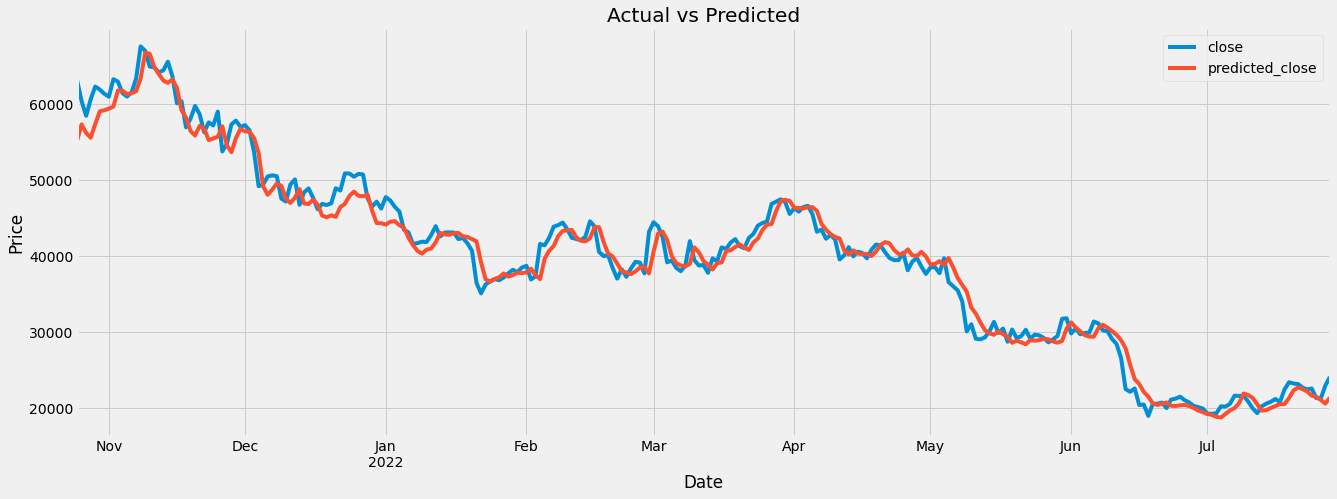

In [389]:
new_df[['close','predicted_close']].plot(figsize=(20,7))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted')
plt.show()

In [390]:
# Creating a dataframe and adding 6 months to existing index 
new_df2 = new_df.append(pd.DataFrame(columns=new_df.columns,index=pd.date_range(start=new_df.index[-1], periods=11, freq='D', closed='right')))

upcoming_prediction = pd.DataFrame(columns=df.columns,index=new_df2.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

curr_seq = test_seq[-1:]

for i in range(-10,0):
    up_pred = model.predict(curr_seq)
    upcoming_prediction.iloc[i] = up_pred
    curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
    curr_seq = curr_seq.reshape(test_seq[-1:].shape)

upcoming_prediction[df.columns] = MMS.inverse_transform(upcoming_prediction[df.columns])

1/1 [==============================] - 0s 15ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 6 and the array at index 1 has size 1

<ipython-input-271-2b90c02b608b>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fg.show()


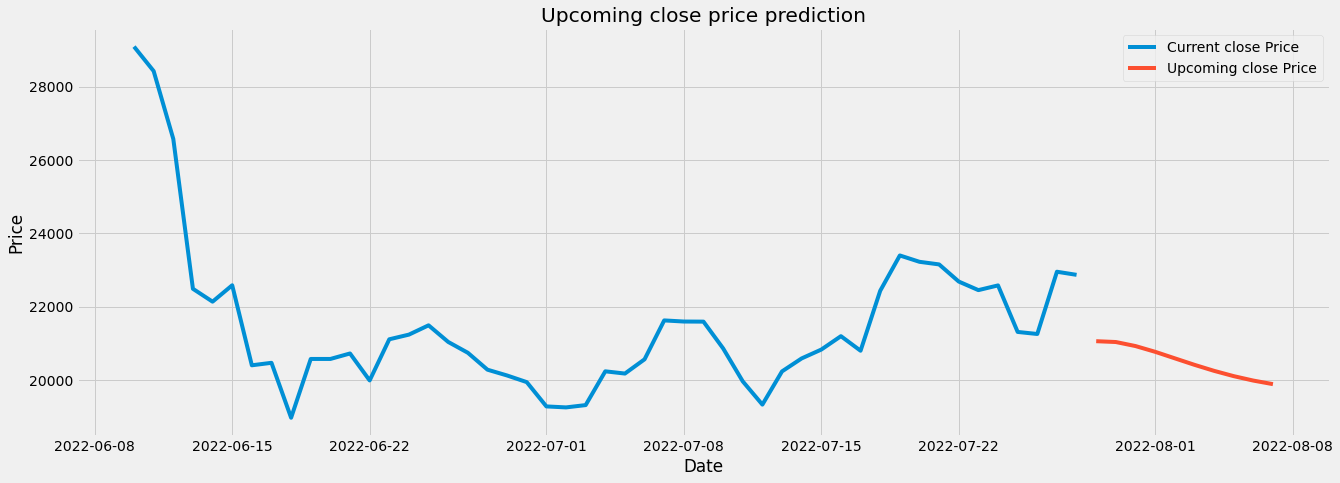

In [ ]:
fg,ax=plt.subplots(figsize=(20,7))
ax.plot(new_df2.loc['2022-06-10':,'close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2022-06-10':,'close'],label='Upcoming close Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Upcoming close price prediction')
ax.legend()
fg.show()